In [1]:
from functions import *

2024-11-22 11:19:51.311939: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-22 11:19:51.332051: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-22 11:19:51.338319: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-22 11:19:51.354478: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-22 11:19:52.518168: W tensorflow/compiler/tf2

In [2]:
import matplotlib.pyplot as plt
import glob
from skimage.transform import resize
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import geopandas as gpd
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib
import seaborn as sns
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
import glob
import time
from datetime import datetime
from collections import Counter
from PIL import Image
import numpy as np
from tensorflow.keras.models import load_model
from rasterio.windows import Window

## Load model

In [4]:
tf.get_logger().setLevel('ERROR') 
model_name = 'baseline_CNN'
model = load_model(f'../models/{model_name}.h5')

2024-11-22 11:19:53.880340: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 10530 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1080 Ti, pci bus id: 0000:02:00.0, compute capability: 6.1
2024-11-22 11:19:53.880947: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 10532 MB memory:  -> device: 1, name: NVIDIA GeForce GTX 1080 Ti, pci bus id: 0000:81:00.0, compute capability: 6.1


## Load data

In [5]:
filt_alt = False 
W=16
split='random'
inputs=['lst','ndvi']
if W==128:
        data_folder = '../data/preprocessed/'
else:
    data_folder = f'../data/preprocessed/{W}x{W}/'
        
data = load_all_data(
source_folder='../data/external/shp/river_cells_oficial',
source_path=data_folder,
data_paths= inputs,
filter_altitude=filt_alt,
W=W,
time_split=True if split=='time' else False)

lst : (1487, 16, 16, 3)
ndvi : (1487, 16, 16)


In [6]:
total_data, total_times, data_targets, labels = data
cosine_months, sine_months, cos_to_month = get_months_vectorized(total_times['lst'])
lat, lon = get_lat_lon(labels)
discharge = get_discharge(labels, total_times['lst'])
additional_inputs = np.column_stack((cosine_months, sine_months, lat, lon, discharge))

global_ranges = {}
for inp in inputs:  
    all_images = total_data[inp]  
    global_min = np.min(all_images)
    global_max = np.max(all_images)
    global_ranges[inp] = (global_min, global_max)
    print(f"Variable: {inp}, Min: {global_min}, Max: {global_max}")

expanded_images = []
for inp in inputs:  
    all_images = total_data[inp]  
    min_val, max_val = global_ranges[inp]  
    normalized_images = normalize_min_max(all_images, min_val, max_val)
    if normalized_images.ndim == 3:  
        normalized_images = np.expand_dims(normalized_images, axis=-1)  
    expanded_images.append(normalized_images)
combined_input = np.concatenate(expanded_images, axis=-1)  
input_data = combined_input

train_index, validation_index, test_index = get_split_index('stratified', input_data, data_targets, labels, 1, filt_alt)
validation_input = input_data[validation_index, :] 
validation_target = data_targets[validation_index]
test_input = input_data[test_index, :]
test_target = data_targets[test_index]
train_input = input_data[train_index, :]
train_target = data_targets[train_index]

Variable: lst, Min: 0.0, Max: 255.0
Variable: ndvi, Min: -0.5326488018035889, Max: 0.8705131411552429
yes !!!!!!!!!!


## Load rivers

In [7]:
import os
import fiona
import geopandas as gpd
from shapely.geometry import shape
import matplotlib.pyplot as plt
from shapely.ops import unary_union

river_cells = {}
output_directory = '../data/external/shp/river_cells_oficial'
a=0

for i,riv in enumerate(os.listdir(output_directory)):
    # Check if the file is a shapefile
    try:
        if riv.endswith('.shp'):
            a+=1
            print(f"Processing file: {riv}")
            river = gpd.read_file(os.path.join(output_directory, riv))
            river = river.to_crs("EPSG:4326")
            river_cells[riv.split('station_')[-1].split('.')[0]] = river
            print('Added', riv.split('station_')[-1].split('.')[0])

    except Exception as e:
        print(f"Error processing file: {riv}",e)
        pass

Processing file: station_cell_37.shp
Added cell_37
Processing file: station_cell_8.shp
Added cell_8
Processing file: station_cell_33.shp
Added cell_33
Processing file: station_cell_9.shp
Added cell_9
Processing file: station_cell_42.shp
Added cell_42
Processing file: station_cell_78.shp
Added cell_78
Processing file: station_cell_6.shp
Added cell_6
Processing file: station_cell_46.shp
Added cell_46
Processing file: station_cell_31.shp
Added cell_31
Processing file: station_cell_59.shp
Added cell_59
Processing file: station_cell_63.shp
Added cell_63
Processing file: station_cell_11.shp
Added cell_11
Processing file: station_cell_36.shp
Added cell_36
Processing file: station_cell_65.shp
Added cell_65
Processing file: station_cell_56.shp
Added cell_56
Processing file: station_cell_12.shp
Added cell_12
Processing file: station_cell_72.shp
Added cell_72
Processing file: station_cell_24.shp
Added cell_24
Processing file: station_cell_38.shp
Added cell_38
Processing file: station_cell_80.shp


# Gradients on test set

In [8]:
test_inp_labels={}
test_dates = {}
test_dates_array = np.array(total_times['lst'])[test_index]

for i,l in enumerate(np.array(labels)[test_index]):
    if l not in test_inp_labels:
        test_inp_labels[l] = [test_input[i]]
        test_dates[l] = [test_dates_array[i]]
    else:
        test_inp_labels[l].append(test_input[i])
        test_dates[l].append(test_dates_array[i])
        


In [9]:
from collections import Counter
imgs = Counter(list(np.array(labels)[test_index]))
imgs['cell_13']
len(test_dates)

53

## Create gradients images

In [10]:
for cell, test_images in test_inp_labels.items():
    for i,test_image in enumerate(test_images):
        test_image_tensor = tf.convert_to_tensor(test_image, dtype=tf.float32)
        test_image_tensor = tf.expand_dims(test_image_tensor, axis=0)
        # Use GradientTape to track gradients
        with tf.GradientTape() as tape:
            tape.watch(test_image_tensor)  # Watch the tensor
            preds = model(test_image_tensor, training=False)  # Perform prediction
            target_output = preds[:, 0]  # Assuming target_output is scalar, adjust as needed
        
        # Calculate the gradients
        gradients = tape.gradient(target_output, test_image_tensor)
        
        folder_path = f'../plots/grad_cam/{model_name}/{cell}'
        os.makedirs(folder_path,exist_ok=True)
        clear_directory(folder_path)
        date = test_dates[cell][i]
        image_path = os.path.join(folder_path, f'image_{date}')
        impact_channel = 3
        save_grad_map(gradients, image_path, impact_channel, W, save_numpy=True)

2024-11-22 11:20:36.566981: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907
W0000 00:00:1732270836.675601 2811301 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1732270836.716311 2811301 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1732270836.717064 2811301 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1732270836.718277 2811301 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1732270836.727864 2811301 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1732270836.728434 2811301 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1732270836.730784 2811301 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1732270836.731341 2811301 gpu_t

Saved at ../plots/grad_cam/baseline_CNN/cell_76/image_2013-10
Saved at ../plots/grad_cam/baseline_CNN/cell_76/image_2014-09
Saved at ../plots/grad_cam/baseline_CNN/cell_76/image_2021-09
Saved at ../plots/grad_cam/baseline_CNN/cell_76/image_2015-04
Saved at ../plots/grad_cam/baseline_CNN/cell_76/image_2024-05
Saved at ../plots/grad_cam/baseline_CNN/cell_76/image_2013-08
Saved at ../plots/grad_cam/baseline_CNN/cell_76/image_2017-06
Saved at ../plots/grad_cam/baseline_CNN/cell_76/image_2021-08
Saved at ../plots/grad_cam/baseline_CNN/cell_76/image_2018-02
Saved at ../plots/grad_cam/baseline_CNN/cell_72/image_2013-10
Saved at ../plots/grad_cam/baseline_CNN/cell_72/image_2014-11
Saved at ../plots/grad_cam/baseline_CNN/cell_72/image_2023-06
Saved at ../plots/grad_cam/baseline_CNN/cell_72/image_2024-07
Saved at ../plots/grad_cam/baseline_CNN/cell_22/image_2013-09
Saved at ../plots/grad_cam/baseline_CNN/cell_22/image_2017-10
Saved at ../plots/grad_cam/baseline_CNN/cell_22/image_2020-11
Saved at

## Analyse gradients

#### Load and crop rasters

../data/external/raster_masks/raster_mask_bw_cell_31.tif
(128, 128)
(16, 16)


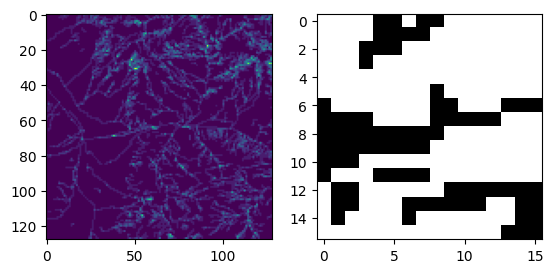

../data/external/raster_masks/raster_mask_bw_cell_71.tif
(128, 128)
(16, 16)


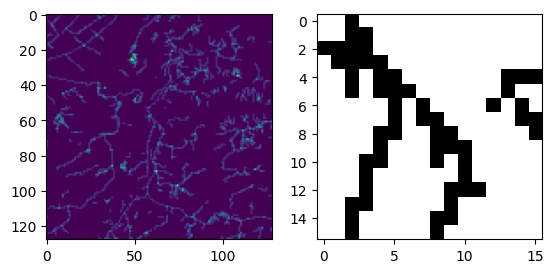

../data/external/raster_masks/raster_mask_bw_cell_60.tif
(128, 128)
(16, 16)


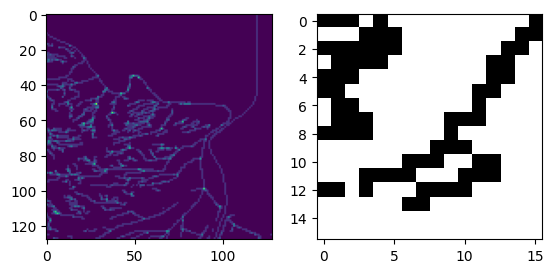

../data/external/raster_masks/raster_mask_bw_cell_32.tif
(128, 128)
(16, 16)


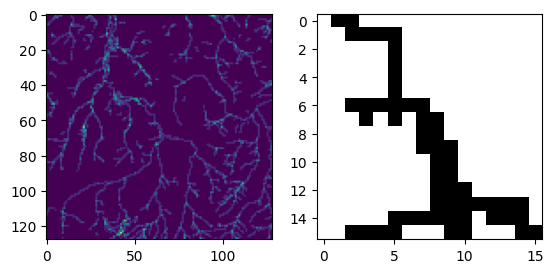

../data/external/raster_masks/raster_mask_bw_cell_1.tif
(128, 128)
(16, 16)


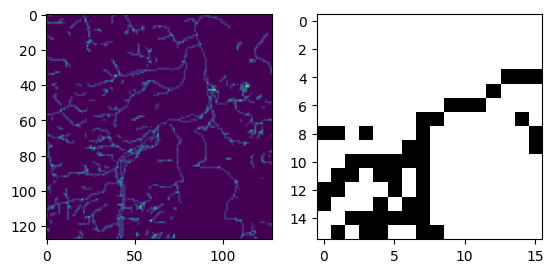

../data/external/raster_masks/raster_mask_bw_cell_77.tif
(128, 128)
(16, 16)


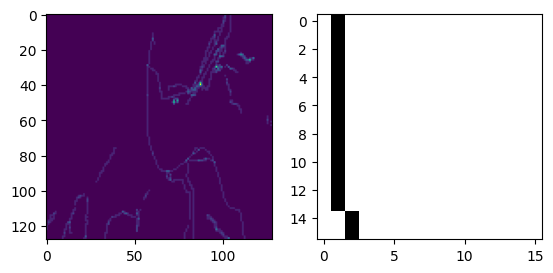

../data/external/raster_masks/raster_mask_bw_cell_45.tif
(128, 128)
(16, 16)


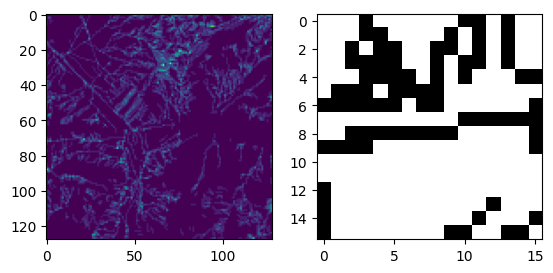

../data/external/raster_masks/raster_mask_bw_cell_74.tif
(128, 128)
(16, 16)


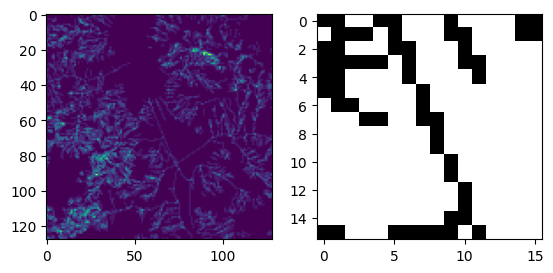

../data/external/raster_masks/raster_mask_bw_cell_35.tif
(128, 128)
(16, 16)


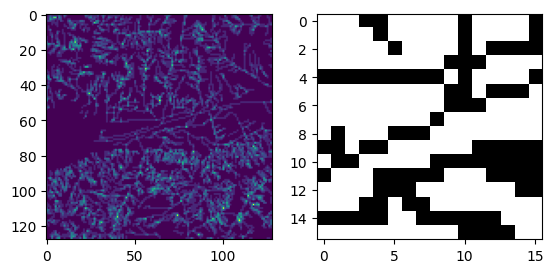

../data/external/raster_masks/raster_mask_bw_cell_25.tif
(128, 128)
(16, 16)


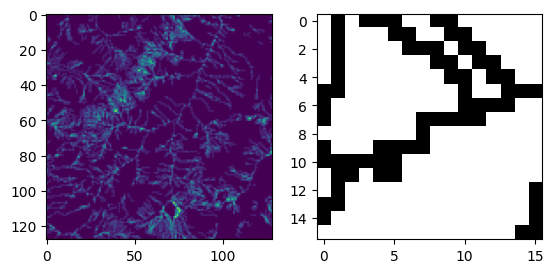

../data/external/raster_masks/raster_mask_bw_cell_2.tif
(128, 128)
(16, 16)
../data/external/raster_masks/raster_mask_bw_cell_64.tif
(128, 128)
(16, 16)
../data/external/raster_masks/raster_mask_bw_cell_21.tif
(128, 128)
(16, 16)
../data/external/raster_masks/raster_mask_bw_cell_51.tif
(128, 128)
(16, 16)
../data/external/raster_masks/raster_mask_bw_cell_49.tif
(128, 128)
(16, 16)
../data/external/raster_masks/raster_mask_bw_cell_12.tif
(128, 128)
(16, 16)
../data/external/raster_masks/raster_mask_bw_cell_58.tif
(128, 128)
(16, 16)
../data/external/raster_masks/raster_mask_bw_cell_46.tif
(128, 128)
(16, 16)
../data/external/raster_masks/raster_mask_bw_cell_53.tif
(128, 128)
(16, 16)
../data/external/raster_masks/raster_mask_bw_cell_40.tif
(128, 128)
(16, 16)
../data/external/raster_masks/raster_mask_bw_cell_55.tif
(128, 128)
(16, 16)
../data/external/raster_masks/raster_mask_bw_cell_5.tif
(128, 128)
(16, 16)
../data/external/raster_masks/raster_mask_bw_cell_39.tif
(128, 128)
(16, 16)
.

In [12]:
dir_path = '../data/external/raster_masks/'
files = os.listdir(dir_path)
river_masks = {}
river_masks_cut = {}
c=0
for raster in files:
    cl_int=raster.split('bw_cell_')[-1].split('.')[0]
    cc = raster.split('bw_')[-1].split('.')[0]
    raster_path = os.path.join(dir_path, raster)
    rast,meta = load_raster(raster_path,False)
    print(raster_path)
    river_masks[cc]=rast
    print(rast.shape)
    rast_cut = crop_raster(raster_path, 16)
    print(rast_cut.shape)
    binary_image = (rast_cut == 0).astype(float)
    river_masks_cut[cc]=binary_image
    if c <10:
        fig, ax = plt.subplots(1,2)
        ax[0].imshow(rast)
        ax[1].imshow(binary_image, cmap="gray", interpolation="nearest")
        plt.show()
    c+=1
    

#### Compute mean magnitude and influence 

Cell: cell_76, Mean Magnitude: 0.0430, Impact: increases


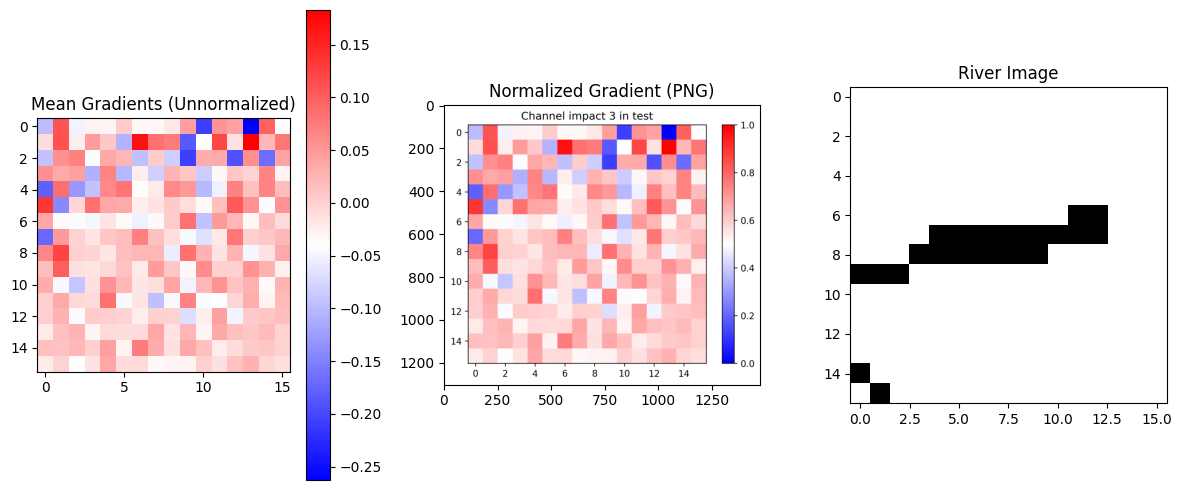

Cell: cell_72, Mean Magnitude: 0.0814, Impact: increases


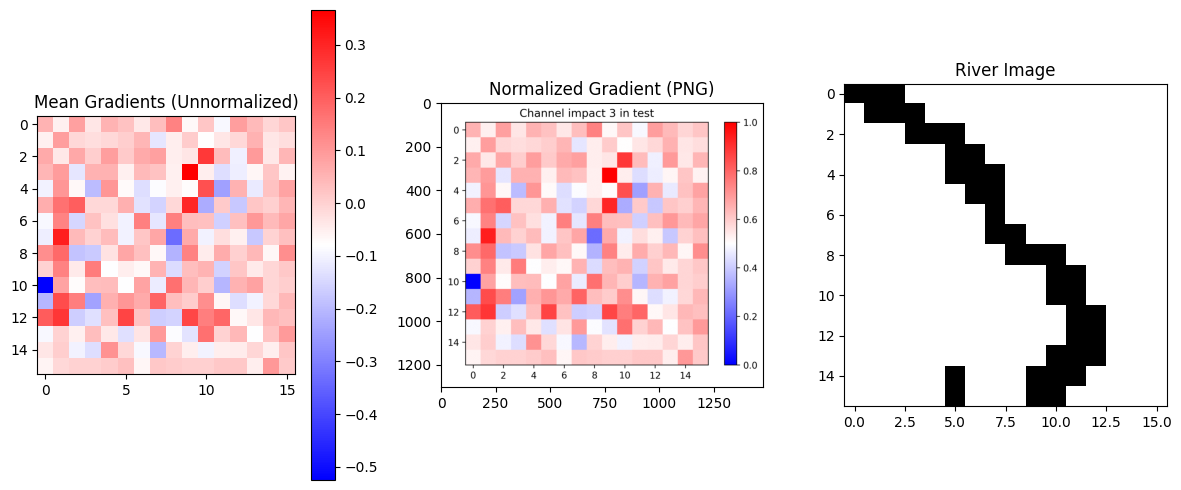

Cell: cell_22, Mean Magnitude: 0.1135, Impact: increases


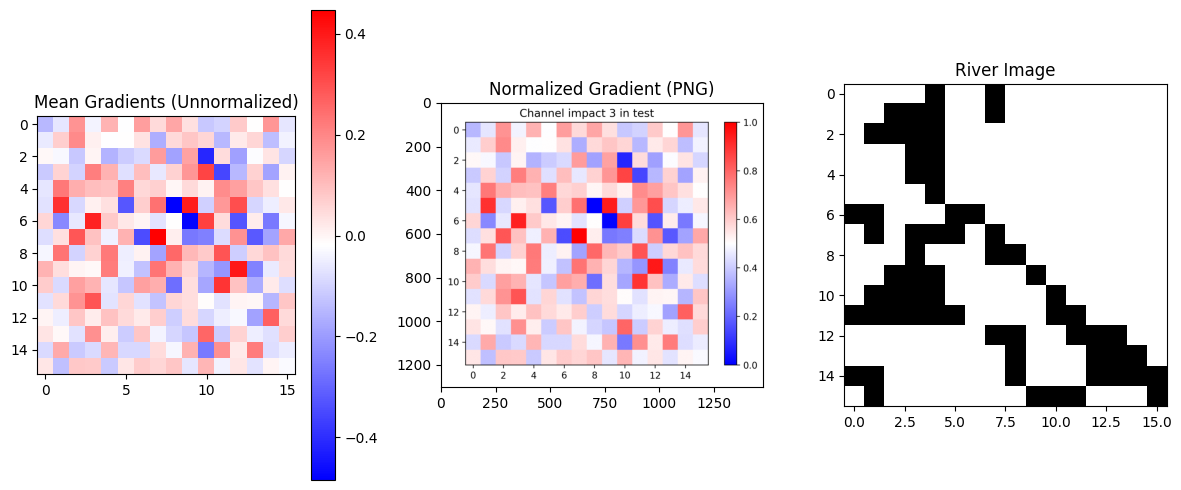

Cell: cell_38, Mean Magnitude: 0.0979, Impact: increases


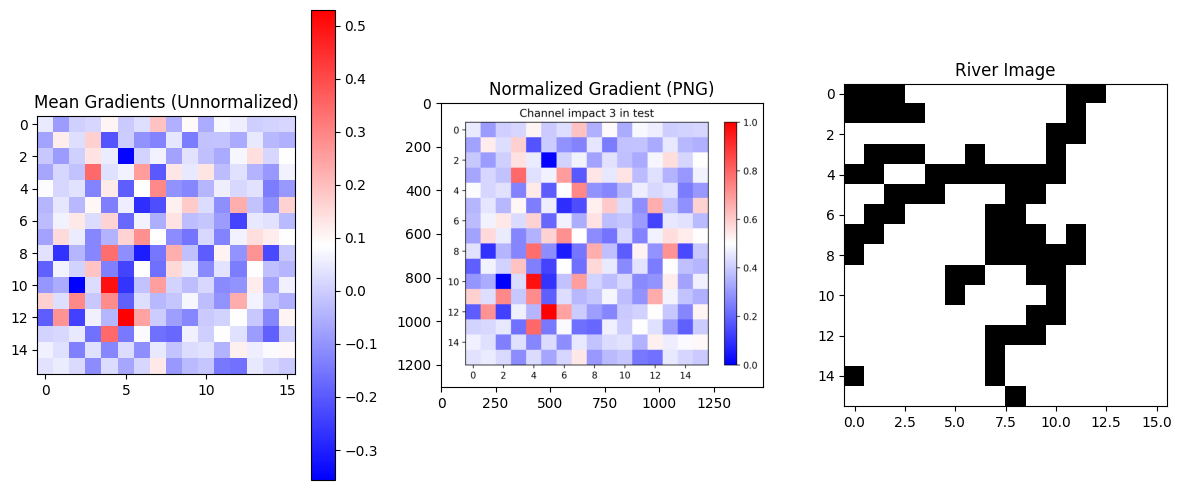

Cell: cell_73, Mean Magnitude: 0.0497, Impact: increases


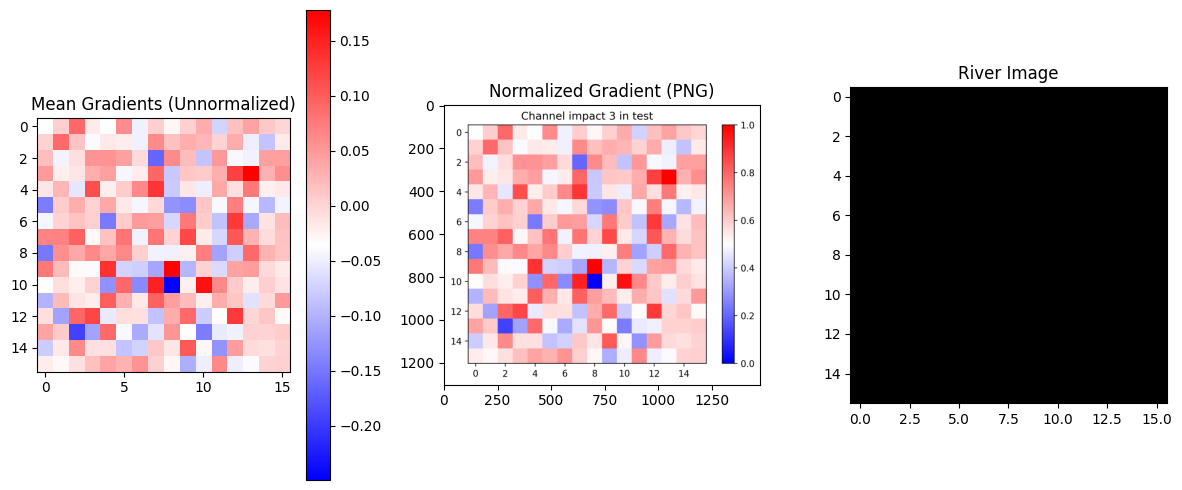

Cell: cell_33, Mean Magnitude: 0.1227, Impact: decreases


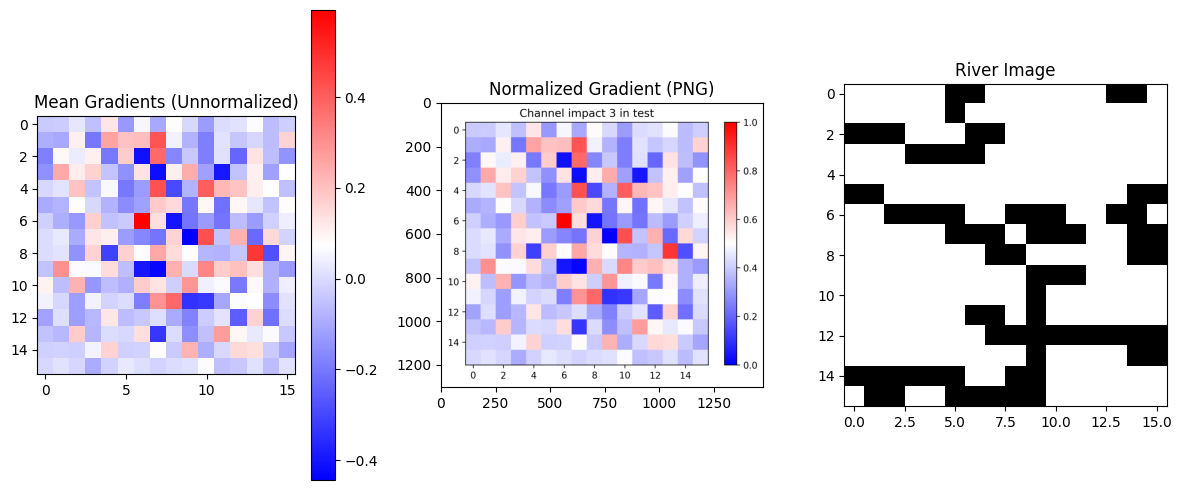

Cell: cell_17, Mean Magnitude: 0.1005, Impact: decreases


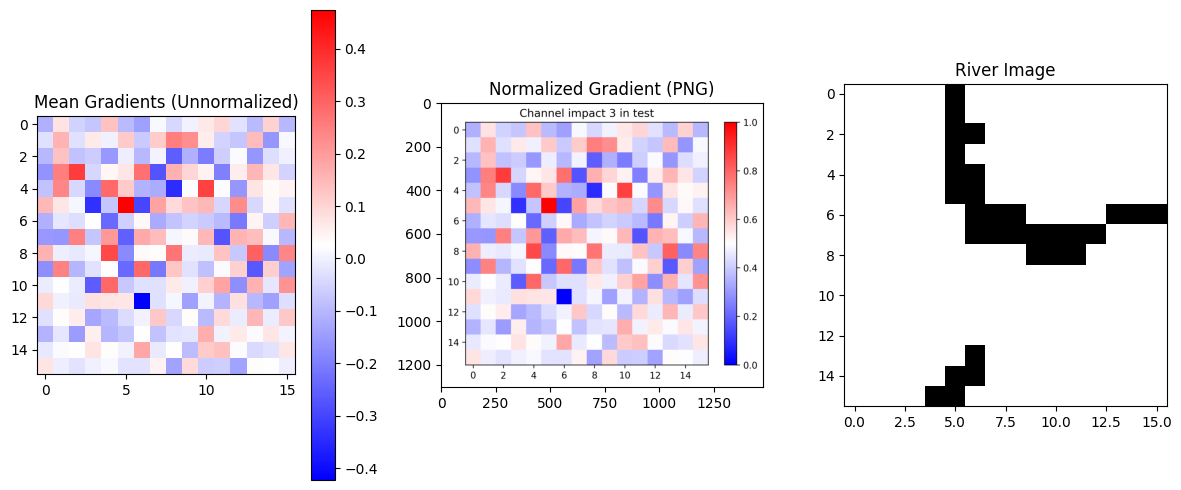

Cell: cell_46, Mean Magnitude: 0.0475, Impact: increases


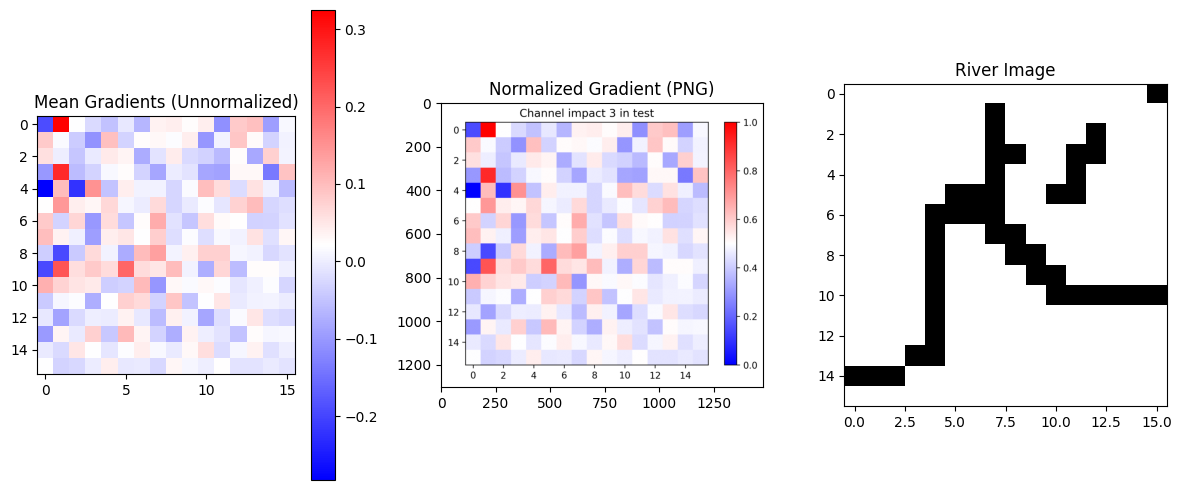

Cell: cell_63, Mean Magnitude: 0.0728, Impact: increases


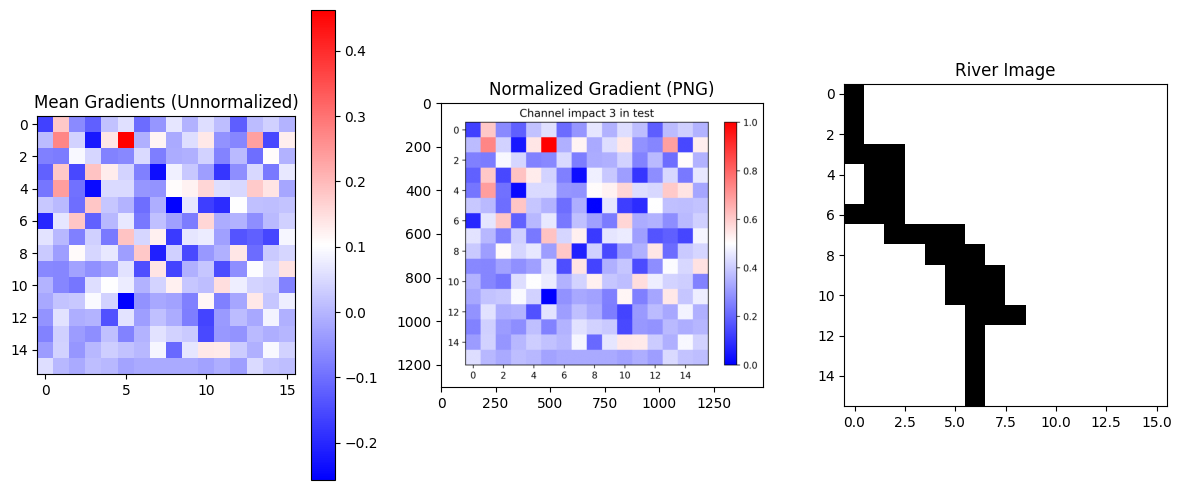

Cell: cell_53, Mean Magnitude: 0.0481, Impact: increases


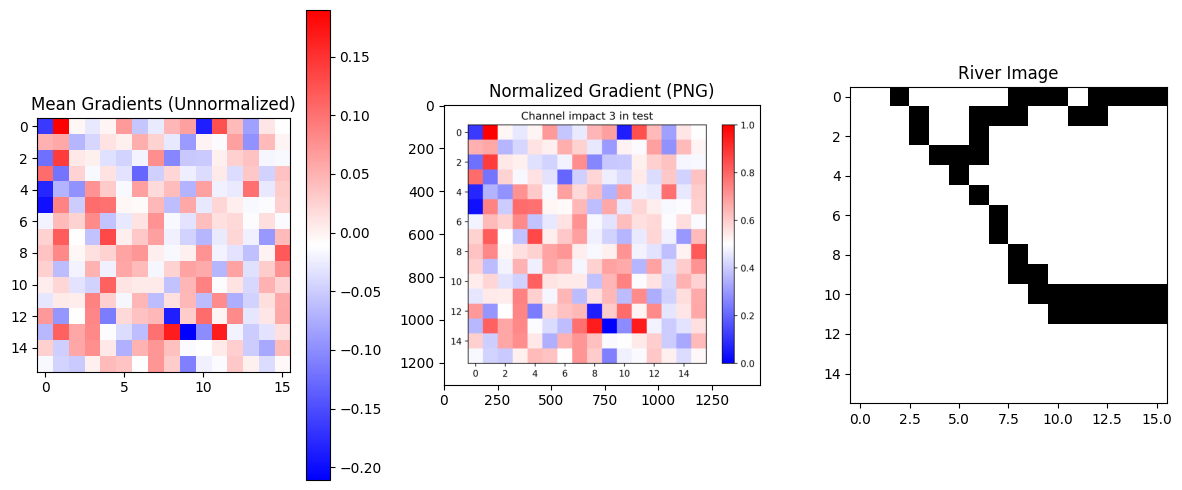

Cell: cell_39, Mean Magnitude: 0.1026, Impact: increases
Cell: cell_59, Mean Magnitude: 0.0752, Impact: increases
Cell: cell_11, Mean Magnitude: 0.0805, Impact: increases
Cell: cell_32, Mean Magnitude: 0.1372, Impact: decreases
Cell: cell_47, Mean Magnitude: 0.0627, Impact: increases
Cell: cell_49, Mean Magnitude: 0.0466, Impact: increases
Cell: cell_9, Mean Magnitude: 0.0720, Impact: increases
Cell: cell_71, Mean Magnitude: 0.0666, Impact: decreases
Cell: cell_5, Mean Magnitude: 0.1185, Impact: increases
Cell: cell_68, Mean Magnitude: 0.0587, Impact: increases
Cell: cell_16, Mean Magnitude: 0.1075, Impact: increases
Cell: cell_26, Mean Magnitude: 0.1261, Impact: increases
Cell: cell_3, Mean Magnitude: 0.0641, Impact: increases
Cell: cell_54, Mean Magnitude: 0.0528, Impact: increases
Cell: cell_28, Mean Magnitude: 0.0937, Impact: decreases
Cell: cell_34, Mean Magnitude: 0.0561, Impact: decreases
Cell: cell_12, Mean Magnitude: 0.0884, Impact: increases
Cell: cell_42, Mean Magnitude: 0.0

In [16]:
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import tensorflow as tf

# Folder containing gradient data
grad_folder = f'../plots/grad_cam/{model_name}'
c = 0
W = 16  # Expected size for resized images
cell_grad_analysis = {}

for cell in test_inp_labels.keys():
    cell_grad_folder = os.path.join(grad_folder, cell)
    grad_images = []
    norm_grad_images = []

    for grad_file_name in os.listdir(cell_grad_folder):
        grad_file_path = os.path.join(cell_grad_folder, grad_file_name)

        # Handle unnormalized gradients from .npy
        if grad_file_name.endswith('.npy'):
            try:
                grad_array = np.load(grad_file_path)  # Load unnormalized gradients
                
                # Resize if necessary
                if grad_array.shape != (W, W):  # Resize if sizes do not match
                    grad_array = tf.image.resize(grad_array[..., np.newaxis], (W, W)).numpy().squeeze()
                
                grad_images.append(grad_array)
            except Exception as e:
                print(f"Error loading {grad_file_name}: {e}")
                continue

        # Handle normalized gradients from .png
        elif grad_file_name.endswith('.png'):
            try:
                norm_grad_image = np.array(Image.open(grad_file_path)) / 255.0  # Normalize PNG values to [0, 1]
                norm_grad_images.append(norm_grad_image)
            except Exception as e:
                print(f"Error loading {grad_file_name}: {e}")
                continue

    # Skip the cell if no gradients are available
    if not grad_images:
        print(f"Cell {cell} has no gradient data. Skipping...")
        continue

    # Convert gradient arrays to NumPy and calculate the mean for unnormalized gradients
    grad_images = np.array(grad_images)
    mean_grad = np.mean(grad_images, axis=0)  # Mean of unnormalized gradients for the cell

    # Handle NaN or invalid shapes
    if np.isnan(mean_grad).any() or mean_grad.size == 0:
        print(f"Cell {cell} produced invalid gradients. Skipping...")
        continue

    # Calculate the mean magnitude and direction of the gradients
    mean_magnitude = np.mean(np.abs(mean_grad))  # Mean magnitude
    mean_direction = np.mean(np.sign(mean_grad))  # Mean direction (+1, 0, -1)
    influence = "increases" if mean_direction > 0 else "decreases"

    cell_grad_analysis[cell]={'magnitude':mean_magnitude, 'direction':mean_direction}
    

    print(f"Cell: {cell}, Mean Magnitude: {mean_magnitude:.4f}, Impact: {influence}")

    # Visualization for the first 10 cells
    if c < 10:
        fig, ax = plt.subplots(1, 3, figsize=(12, 5))

        # Display the mean unnormalized gradient
        im = ax[0].imshow(mean_grad, cmap="bwr")
        fig.colorbar(im, ax=ax[0])
        ax[0].set_title("Mean Gradients (Unnormalized)")

        # Display the first normalized gradient image (if available)
        if norm_grad_images:
            ax[1].imshow(norm_grad_images[0], cmap="bwr")
            ax[1].set_title("Normalized Gradient (PNG)")

        # Display the river mask
        ax[2].imshow(river_masks_cut[cell], cmap="gray", interpolation="nearest")
        ax[2].set_title("River Image")

        plt.tight_layout()
        plt.show()

    c += 1


#### Analyse results and identify high influence locations

In [17]:
import numpy as np

# Separate cells into "increase" and "decrease" based on direction
increase_cells = {cell: data for cell, data in cell_grad_analysis.items() if data["direction"] > 0}
decrease_cells = {cell: data for cell, data in cell_grad_analysis.items() if data["direction"] < 0}

# Extract magnitudes for each group
increase_magnitudes = [data["magnitude"] for data in increase_cells.values()]
decrease_magnitudes = [data["magnitude"] for data in decrease_cells.values()]

# Calculate statistics for each group
increase_mean = np.mean(increase_magnitudes)
increase_std = np.std(increase_magnitudes)
increase_threshold = increase_mean + increase_std  # Threshold for "large" influence

decrease_mean = np.mean(decrease_magnitudes)
decrease_std = np.std(decrease_magnitudes)
decrease_threshold = decrease_mean + decrease_std  # Threshold for "large" influence

# Identify cells with large influence in each group
large_increase_cells = {cell: data["magnitude"] for cell, data in increase_cells.items() if data["magnitude"] > increase_threshold}
large_decrease_cells = {cell: data["magnitude"] for cell, data in decrease_cells.items() if data["magnitude"] > decrease_threshold}

# Output results
print("Increase Cells:")
print(f"  Mean Magnitude: {increase_mean:.4f}, Std: {increase_std:.4f}, Large Threshold: {increase_threshold:.4f}")
print("  Large Influence:")
for cell, mag in large_increase_cells.items():
    print(f"    {cell}: {mag:.4f}")

print("\nDecrease Cells:")
print(f"  Mean Magnitude: {decrease_mean:.4f}, Std: {decrease_std:.4f}, Large Threshold: {decrease_threshold:.4f}")
print("  Large Influence:")
for cell, mag in large_decrease_cells.items():
    print(f"    {cell}: {mag:.4f}")


Increase Cells:
  Mean Magnitude: 0.0797, Std: 0.0258, Large Threshold: 0.1054
  Large Influence:
    cell_22: 0.1135
    cell_5: 0.1185
    cell_16: 0.1075
    cell_26: 0.1261
    cell_35: 0.1224
    cell_55: 0.1288
    cell_74: 0.1152
    cell_29: 0.1196

Decrease Cells:
  Mean Magnitude: 0.0928, Std: 0.0259, Large Threshold: 0.1187
  Large Influence:
    cell_33: 0.1227
    cell_32: 0.1372
    cell_31: 0.1193


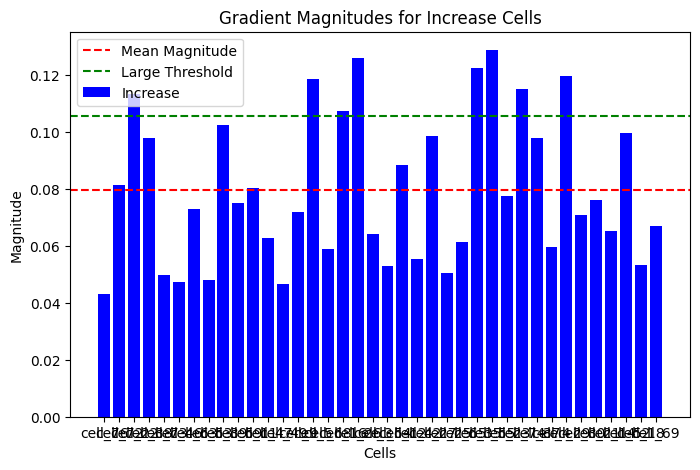

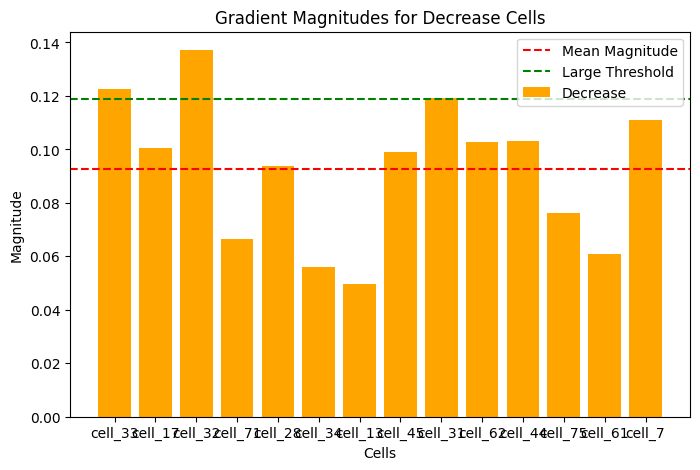

In [18]:
import matplotlib.pyplot as plt

# Plot Increase Magnitudes
plt.figure(figsize=(8, 5))
plt.bar(increase_cells.keys(), increase_magnitudes, color="blue", label="Increase")
plt.axhline(y=increase_mean, color="r", linestyle="--", label="Mean Magnitude")
plt.axhline(y=increase_threshold, color="g", linestyle="--", label="Large Threshold")
plt.title("Gradient Magnitudes for Increase Cells")
plt.xlabel("Cells")
plt.ylabel("Magnitude")
plt.legend()
plt.show()

# Plot Decrease Magnitudes
plt.figure(figsize=(8, 5))
plt.bar(decrease_cells.keys(), decrease_magnitudes, color="orange", label="Decrease")
plt.axhline(y=decrease_mean, color="r", linestyle="--", label="Mean Magnitude")
plt.axhline(y=decrease_threshold, color="g", linestyle="--", label="Large Threshold")
plt.title("Gradient Magnitudes for Decrease Cells")
plt.xlabel("Cells")
plt.ylabel("Magnitude")
plt.legend()
plt.show()
